In [73]:
import pandas as pd

data = pd.read_csv('~/ctgan/data/annual_KY_3class_stdDev_6ft.csv')
data.head()

,Total Radiation (MJ/m^2),Total Rainfall (mm),Avg Air Temp (C),Avg Min Temp (C),Avg Max Temp (C),Avg Soil Moisture (%),Class
0,3273.52,804.6,17.607333,12.617071,22.598714,0.313481,2
1,3273.52,804.6,17.607333,12.617071,22.598714,0.313481,2
2,3273.52,804.6,17.607333,12.617071,22.598714,0.313481,2
3,3273.52,804.6,17.607333,12.617071,22.598714,0.313481,2
4,3273.52,804.6,17.607333,12.617071,22.598714,0.313481,2


In [74]:
from sdv.tabular import CTGAN

model = CTGAN()
model.fit(data)

In [75]:
new_data = model.sample(1000)

In [76]:
new_data.to_csv('~/ctgan/data/synthData/rf_dt_6ft_1k_snlt_02_1106.csv')
new_data.head()

,Total Radiation (MJ/m^2),Total Rainfall (mm),Avg Air Temp (C),Avg Min Temp (C),Avg Max Temp (C),Avg Soil Moisture (%),Class
0,3584.99,1043.2,20.106211,15.904745,27.668555,0.272962,2
1,3197.95,953.8,17.607333,14.861673,25.921775,0.286968,1
2,3528.19,822.2,20.009450,12.889411,25.786828,0.272962,1
3,3486.94,860.6,17.607333,14.656916,26.054453,0.291860,1
4,3520.18,798.4,20.685484,14.194830,29.253107,0.288324,3


In [77]:
# get aggregate data
targetDataLoc = '~/ctgan/data/annual_GA_3class_1varPerYear_stdDev.csv'
#aggDataLoc = 'data/synth1_GA_only_063022.csv'

aggDf = new_data #pd.read_csv(aggDataLoc)
#aggDf = aggDf.drop("Unnamed: 0",axis=1)
targetDf = pd.read_csv(targetDataLoc)
#targetDf = targetDf.drop("Unnamed: 0",axis=1)

In [78]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVR  # support vector machines regression
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor # adaboost for regression
# saving models
# from sklearn.externals import joblib
import joblib

# import the API
APILoc = 'API/'

import sys
sys.path.insert(0, APILoc)

from API import *

In [79]:
# filter out the features that will not be used by the machine learning models

# the features to keep:
# xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Time Since Last Harvest (Days)", "Total Radiation (MJ/m^2)",
#                "Total Rainfall (mm)", "Avg Air Temp (C)", "Avg Min Temp (C)", "Avg Max Temp (C)",
#                  "Avg Soil Moisture (%)", "Day Length (hrs)"], "Percent Cover (%)"]

# xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Total Radiation (MJ/m^2)",
#                "Total Rainfall (mm)", "Avg Air Temp (C)", "Avg Min Temp (C)", "Avg Max Temp (C)",
#                  "Avg Soil Moisture (%)"]

xColumnsToKeep = ["Total Radiation (MJ/m^2)","Total Rainfall (mm)", "Avg Air Temp (C)", "Avg Min Temp (C)", 
                  "Avg Max Temp (C)","Avg Soil Moisture (%)"]


#xColumnsToKeep = ["Julian Day", "Time Since Sown (Days)", "Total Radiation (MJ/m^2)", "Total Rainfall (mm)"]

# the target to keep
yColumnsToKeep = ["Class"]

# get a dataframe containing the features and the targets
xDf = aggDf[xColumnsToKeep]
test_xDf = targetDf[xColumnsToKeep]
yDf = aggDf[yColumnsToKeep]
test_yDf = targetDf[yColumnsToKeep]

# reset the index
xDf = xDf.reset_index(drop=True)
yDf = yDf.reset_index(drop=True)
test_xDf = test_xDf.reset_index(drop=True)
test_yDf = test_yDf.reset_index(drop=True)

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)

xCols = list(xDf)

In [80]:
# hide the warnings because training the neural network caues lots of warnings.
import warnings
warnings.filterwarnings('ignore')

# make the parameter grids for sklearn's gridsearchcv
rfParamGrid = {
        'model__n_estimators': [5, 10, 25, 50, 100], # Number of estimators
        'model__max_depth': [5, 10, 15, 20], # Maximum depth of the tree
        'model__criterion': ["gini"]
    }
knnParamGrid ={
        'model__n_neighbors':[2,5,10],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [5, 10, 30, 50]    
    }
svrParamGrid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 1.0, 5.0, 10.0],
        'model__gamma': ["scale", "auto"],
        'model__degree': [2,3,4,5]
    }
nnParamGrid = {
        'model__hidden_layer_sizes':[(3), (5), (10), (3,3), (5,5), (7,7)],
        'model__solver': ['sgd', 'adam'],
        'model__learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'model__learning_rate_init': [0.1, 0.01, 0.001]      
    }

linRegParamGrid = {}

bayesParamGrid={
        'model__n_iter':[100,300,500]
    }

dtParamGrid = {
    'model__criterion': ['gini'],
    'model__max_depth': [5,10,25,50,100]
    }

aModelList = [(RandomForestClassifier(), rfParamGrid, "rfTup2.pkl"),
              #(KNeighborsRegressor(), knnParamGrid, "knnTup.pkl"),
              #(SVR(), svrParamGrid, "svrTup.pkl"),
             #(MLPClassifier(), nnParamGrid, "nnTup.pkl")]#,
             #(LinearRegression(), linRegParamGrid, "linRegTup.pkl"),
             #(BayesianRidge(), bayesParamGrid, "bayesTup.pkl"),
             (DecisionTreeClassifier(), dtParamGrid, "dtTup2.pkl")]

N = 10
workingDir = 'working_dir'
numFeatures = 6 # 11

model:  rfTup2
Avg MAE:  1016.0
Avg R squared:  -0.3
Best MAE:  920.0
Best R squared:  -0.092
Parameters of the best model:  {'model__criterion': 'gini', 'model__max_depth': 5, 'model__n_estimators': 50}
Features selected by best model:  ['Total Radiation (MJ/m^2)', 'Total Rainfall (mm)', 'Avg Air Temp (C)', 'Avg Min Temp (C)', 'Avg Max Temp (C)', 'Avg Soil Moisture (%)']
Accuracy:  0.43
f1 score:  0.23389450056116723
mcc:  -0.1161869611647788
 
test results on our test data: 


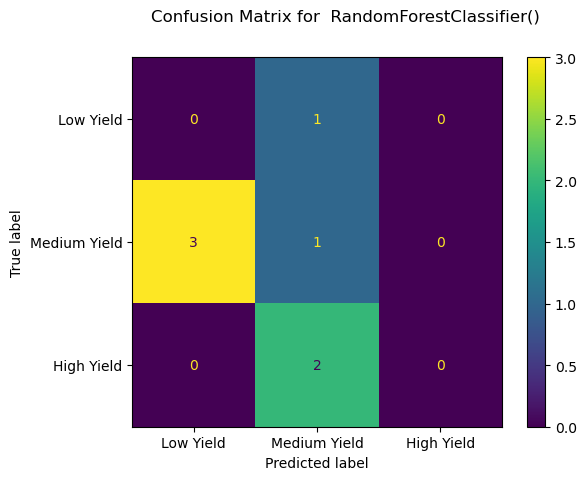

results:
MAE:  0.8571428571428571
R sq:  -1.0999999999999996
accuracy score for DA/TDA:  0.14285714285714285
model:  dtTup2
Avg MAE:  1098.0
Avg R squared:  -0.458
Best MAE:  1060.0
Best R squared:  -0.229
Parameters of the best model:  {'model__criterion': 'gini', 'model__max_depth': 5}
Features selected by best model:  ['Total Radiation (MJ/m^2)', 'Total Rainfall (mm)', 'Avg Air Temp (C)', 'Avg Min Temp (C)', 'Avg Max Temp (C)', 'Avg Soil Moisture (%)']
Accuracy:  0.45
f1 score:  0.2507954332771851
mcc:  -0.059474317662627986
 
test results on our test data: 


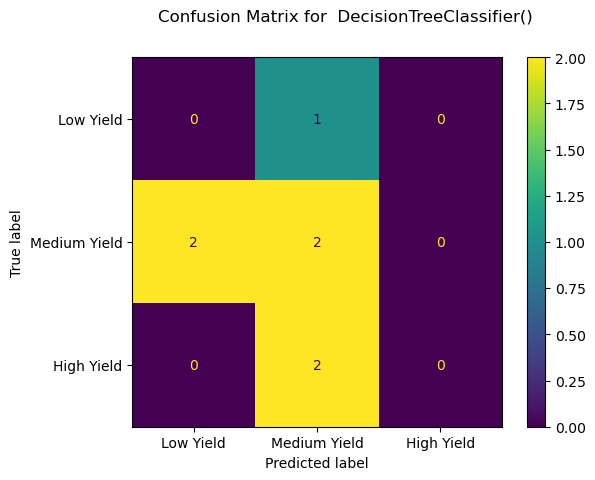

results:
MAE:  0.7142857142857143
R sq:  -0.7499999999999998
accuracy score for DA/TDA:  0.2857142857142857


In [81]:
saveMLResults(test_xDf, test_yDf, N, xDf, yDf, aModelList, workingDir, numFeatures, printResults=True)